<h2>Data Analytics Homework 2 - David Mallon (08597596) & Paul O'Donovan (22208104)</h2>

Prepare a data quality report for your CSV file. 

In [190]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from patsy import dmatrices

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.tree import export_graphviz

import graphviz
from graphviz import Source

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [191]:
# Reading from a csv file, into a data frame
df1 = pd.read_csv('covid19-cdc-22208104.csv', keep_default_na=True, delimiter=',', engine='python', skipinitialspace=True)

# Reading from a csv file, into a data frame
df2 = pd.read_csv('covid19-cdc-8597596.csv', keep_default_na=True, delimiter=',', engine='python', skipinitialspace=True)

# Concatenate the data frames
df = pd.concat([df1, df2], axis=0)

In [192]:
# Check how many rows and columns this dataframe has
print("Number of rows and columns:", df.shape)

# Show first 5 rows of data frame
# The rows are indexed starting from 0
df.head(5)

Number of rows and columns: (40000, 19)


,case_month,res_state,state_fips_code,res_county,county_fips_code,age_group,sex,race,ethnicity,case_positive_specimen_interval,case_onset_interval,process,exposure_yn,current_status,symptom_status,hosp_yn,icu_yn,death_yn,underlying_conditions_yn
0,2021-04,IL,17.0,COOK,17031.0,50 to 64 years,Male,White,Hispanic/Latino,1.0,0.0,Missing,Missing,Laboratory-confirmed case,Missing,Yes,Missing,Yes,NaN
1,2020-04,MA,25.0,SUFFOLK,25025.0,65+ years,Male,White,Non-Hispanic/Latino,0.0,NaN,Missing,Missing,Laboratory-confirmed case,Missing,Yes,Missing,Yes,NaN
2,2020-11,PA,42.0,PHILADELPHIA,42101.0,65+ years,Female,White,Unknown,0.0,NaN,Missing,Yes,Laboratory-confirmed case,Symptomatic,Unknown,Unknown,Yes,NaN
3,2021-12,NY,36.0,QUEENS,36081.0,65+ years,Female,Asian,Non-Hispanic/Latino,0.0,NaN,Missing,Missing,Laboratory-confirmed case,Unknown,Yes,Yes,Yes,Yes
4,2022-01,AZ,4.0,MARICOPA,4013.0,65+ years,Male,White,Non-Hispanic/Latino,NaN,NaN,Missing,Missing,Probable Case,Missing,Missing,Missing,Yes,NaN


In [193]:
#Get a summary of columns
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 0 to 19999
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   case_month                       40000 non-null  object 
 1   res_state                        39999 non-null  object 
 2   state_fips_code                  39999 non-null  float64
 3   res_county                       37702 non-null  object 
 4   county_fips_code                 37702 non-null  float64
 5   age_group                        39740 non-null  object 
 6   sex                              39234 non-null  object 
 7   race                             35303 non-null  object 
 8   ethnicity                        34875 non-null  object 
 9   case_positive_specimen_interval  20865 non-null  float64
 10  case_onset_interval              17552 non-null  float64
 11  process                          40000 non-null  object 
 12  exposure_yn       

In [194]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
state_fips_code,39999.0,29.556239,13.341753,1.0,19.0,34.0,37.0,78.0
county_fips_code,37702.0,29578.939605,13211.869250,1001.0,18163.0,34017.0,37183.0,56039.0
case_positive_specimen_interval,20865.0,0.194201,2.312371,-90.0,0.0,0.0,0.0,94.0
case_onset_interval,17552.0,-0.057714,1.800305,-60.0,0.0,0.0,0.0,69.0


Per the above results, I am missing 2298 pieces of information for county_fips_code. This is fine in my opinion as I have the almost full 39999 pieces of information for state_fips_code which will suffice for the purposes of this examination. The county_fips_code is not crucial and is sufficiently replaced and supplemented by the state_fips_code data.

In relation to the missing / blank data for case_positive_specimen_interval, I will consider both sets of data in section 2 (my data quality plan) as I will consider their inclusion, possible amendments/corrections and any links that can be made with other provided information.

In [195]:
# Look at column names. Ensure there are not spaces in or after the name
df.columns

Index(['case_month', 'res_state', 'state_fips_code', 'res_county',
       'county_fips_code', 'age_group', 'sex', 'race', 'ethnicity',
       'case_positive_specimen_interval', 'case_onset_interval', 'process',
       'exposure_yn', 'current_status', 'symptom_status', 'hosp_yn', 'icu_yn',
       'death_yn', 'underlying_conditions_yn'],
      dtype='object')

Neither the state_fips_code and county_fips_code data represents a continuous range of values, but instead represent specific states and counties respectively, which are both categorical attributes. Both these datasets are better treated as categorical variables, which will help us understand the distribution of the data and any relationships or patterns that may exist between the state codes and other variables in the dataset.

In [196]:
df["state_fips_code"] = df["state_fips_code"].astype("object")
df["county_fips_code"] = df["county_fips_code"].astype("object")

#Select all columns of type 'object'
object_columns = df.select_dtypes(['object']).columns

#Convert selected columns to type 'category' purely for ease of reference when reviewing categorical and continuous characteristics.
for column in object_columns:
    df[column] = df[column].astype('category')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 0 to 19999
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   case_month                       40000 non-null  category
 1   res_state                        39999 non-null  category
 2   state_fips_code                  39999 non-null  category
 3   res_county                       37702 non-null  category
 4   county_fips_code                 37702 non-null  category
 5   age_group                        39740 non-null  category
 6   sex                              39234 non-null  category
 7   race                             35303 non-null  category
 8   ethnicity                        34875 non-null  category
 9   case_positive_specimen_interval  20865 non-null  float64 
 10  case_onset_interval              17552 non-null  float64 
 11  process                          40000 non-null  category
 12  expo

Convert the features to their appropriate data types (e.g., decide which features are more appropriate as continuous and which ones as categorical types).

Look for duplicate rows and columns. Consider whether it makes sense to keep them or drop them.

In [197]:
#Print the number of duplicates, without the original rows that were duplicated
print('Number of duplicate (excluding first original occurence) rows in the table is: ', df.duplicated().sum())

# Check for duplicate rows. 
# Use "keep=False" to mark all duplicates as true, including the original rows that were duplicated.
print('Number of duplicate rows (including first original occurence) in the table is:', df[df.duplicated(keep=False)].shape[0])

Number of duplicate (excluding first original occurence) rows in the table is:  3639
Number of duplicate rows (including first original occurence) in the table is: 6178


In [198]:
view_duplicates = df[df.duplicated(keep = False)]
view_duplicates.to_csv('duplicate_columns.csv', index=False)

Having reviewed the duplicates (as set out in a separate csv I prepared), I was satisfied that these should stay in the dataframe. As the information contained therein has been intentionally anonymised, there are not enough specific identifiers relating to each patient's data which would justify removing the duplicates. I believe it better to err on the side of caution and not remove what could (and probably is) information recorded which is identical but actually relates to different individuals, rather than remove valid information on the assumption that it is a duplicate entry.

In [199]:
# quick view of duplicates

duplicate = df[df.duplicated()]
 
print(duplicate)
 

      case_month res_state state_fips_code   res_county county_fips_code  \
235      2020-03        NY            36.0       QUEENS          36081.0   
274      2021-01        CA             6.0  LOS ANGELES           6037.0   
289      2020-12        CA             6.0  LOS ANGELES           6037.0   
373      2021-01        FL            12.0   MIAMI-DADE          12086.0   
476      2021-12        IL            17.0         COOK          17031.0   
...          ...       ...             ...          ...              ...   
19933    2020-07        TX            48.0      TARRANT          48439.0   
19934    2022-01        IN            18.0       MARION          18097.0   
19941    2021-12        NJ            34.0        OCEAN          34029.0   
19944    2022-01        IN            18.0       GIBSON          18051.0   
19972    2022-01        MN            27.0     HENNEPIN          27053.0   

            age_group      sex     race            ethnicity  \
235         65+ years  

Checking if any duplicate columns present.

Function sourced from https://www.geeksforgeeks.org/how-to-find-drop-duplicate-columns-in-a-pandas-dataframe/ 

In [200]:
def getDuplicateColumns(df):
    duplicateColumnNames = set()
 
    for x in range(df.shape[1]):
        col = df.iloc[:, x]
        for y in range(x + 1, df.shape[1]):
            otherCol = df.iloc[:, y]
            if col.equals(otherCol):
                duplicateColumnNames.add(df.columns.values[y])
    return list(duplicateColumnNames)

duplicateColNames = getDuplicateColumns(df)

for column in duplicateColNames:
    print('Column Name : ', column)

In [201]:
# Check for duplicate columns - additional test
#First transpose the df so columns become rows, then apply the same check as above
dfT = df.T
print("Number of duplicate (excluding first) columns in the table is: ", dfT.duplicated().sum())
print("Number of duplicate (including first) columns in the table is: ",  dfT[dfT.duplicated(keep=False)].shape[0])

Number of duplicate (excluding first) columns in the table is:  0
Number of duplicate (including first) columns in the table is:  0


Look for constant columns. Consider whether it makes sense to keep them or drop them.

In [202]:
# Check the number of unique values in each column
nunique_values = df.nunique()

constant_columns = nunique_values[nunique_values == 1].index
constant_column_names = list(constant_columns)

# Print the names of the constant columns
print("Constant columns: ", constant_column_names)

Constant columns:  []


In [203]:
c = [c for c in df.columns if len(set(df[c])) == 1]
print ("Constant columns: ", c)

Constant columns:  []


There are no 100% constant columns present in my dataset, therefore no adjustment is required.
I have rechecked the data basing it on a 90% occurrence (when excluding empty cells) for completeness per the below cells and I would opine that the information in both the 'process' and 'underlying_conditions_yn' cells warrant inclusion in the cleaned dataframe due to weighing up the results against the number of empty cells with missing information. Further examination of these features is undertaken in part two of this assignment.

In [204]:
#Calculate the percentage of each value in each column, including empty cells
value_percentages = df.apply(lambda x: x.value_counts(normalize=True, dropna=False).max())

#Select only the columns where the maximum value percentage is >= 0.95
constant_columns = value_percentages[value_percentages >= 0.90].index

#List the names of the constant columns
constant_column_names = list(constant_columns)

#Print the names of the constant columns
print("Constant columns: ", constant_column_names)

Constant columns:  ['process', 'underlying_conditions_yn']


The information from 'underlying_conditions_yn' is still useful when looking for consideration based on the above commentary. This information will also be useful when preparing my data quality plan and expected results from the bar plots. Further commentary is provided on my logic is provided in both my Data Quality Report and Data Quality Plan.

In [205]:
df['underlying_conditions_yn'].value_counts()

Yes    3444
No       51
Name: underlying_conditions_yn, dtype: int64

case_onset_interval - Drop column as this feature has little effect on target outcome <br>
case_positive_specimen_interval - Drop column as this feature has little effect on target outcome<br>
res_county - Drop column as it is like a duplicate feature to county_fips_code and it is not a unique identifier (eg county with same name in different states).<br>
process - Drop column as this feature has little effect on target outcome and has most values missing.<br>
exposure_yn - Drop column as this feature has little effect on target outcome and has most values missing.<br>
symptom_status - Drop column as this feature has little effect on target outcome and is missing >50% of values<br>


Convert unknown and null to missing, and take missing values into account when analysing data for the following; <br>
age_group<br>
sex<br>
race <br>
ethnicity<br>
hosp_yn<br>
icu_yn<br>


Convert null to missing, and take missing values into account when analysing data 
underlying_conditions_yn

In [206]:
# drop the specified columns
df = df.drop(columns=["case_onset_interval", "case_positive_specimen_interval", "res_county", "process", "exposure_yn", "symptom_status", "state_fips_code"])
# replace "unknown" and "null" values with NaN
df = df.replace(["unknown", "null"], np.nan)
# replace "null" values with NaN
df["underlying_conditions_yn"] = df["underlying_conditions_yn"].replace("null", np.nan)

# Q. Save your updated/cleaned data frame to a new csv file.

In [207]:
# Reading cleaned data into a data frame
df = pd.read_csv('cleaned_data_hw2.csv')

#Select all columns of type 'object'
object_columns = df.select_dtypes(['object']).columns

#Convert selected columns to type 'category' purely for ease of reference when reviewing categorical and continuous characteristics.
for column in object_columns:
    df[column] = df[column].astype('category')

# Convert case_month to datetime format
df['case_month'] = pd.to_datetime(df['case_month'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   case_month                40000 non-null  category
 1   res_state                 39999 non-null  category
 2   county_fips_code          37702 non-null  float64 
 3   age_group                 39740 non-null  category
 4   sex                       39234 non-null  category
 5   race                      35303 non-null  category
 6   ethnicity                 34875 non-null  category
 7   current_status            40000 non-null  category
 8   hosp_yn                   40000 non-null  category
 9   icu_yn                    40000 non-null  category
 10  death_yn                  40000 non-null  category
 11  underlying_conditions_yn  3495 non-null   category
dtypes: category(11), float64(1)
memory usage: 746.8 KB


In [208]:
df.to_csv('cleaned_data_hw2.csv', index=False)

The goal in this homework is to work with the data to build and evaluate prediction models that capture the relationship between the descriptive features and the target feature **death_yn**. For this homework you are asked to use the same dataset allocated to you in Homework1 (you can use your cleaned/prepared CSV from Homework1 or start from the raw dataset, clean it according to concepts covered in the lectures/labs, then use it for training prediction models). To use the 2 individual files allocated for Homework1, you can merge them first, then clean the resulting dataset, before starting on Homework2 requirements.
 
There are 5 parts for this homework. Each part has an indicative maximum percentage given in brackets, e.g., part (1) has a maximum of 25% shown as [25]. The total that can be achieved is 100.


(1). [25] **Data Understanding and Preparation:** Exploring relationships between feature pairs and selecting/transforming promising features based on a given training set.

    
    

After importing the cleaned csv, as a reminder we will check the shape, inspect the datatypes and check for any remaining null values

In [209]:
df.shape

(40000, 12)

In [210]:
df.dtypes

case_month                  category
res_state                   category
county_fips_code             float64
age_group                   category
sex                         category
race                        category
ethnicity                   category
current_status              category
hosp_yn                     category
icu_yn                      category
death_yn                    category
underlying_conditions_yn    category
dtype: object

In [211]:
df.isna().sum()

case_month                      0
res_state                       1
county_fips_code             2298
age_group                     260
sex                           766
race                         4697
ethnicity                    5125
current_status                  0
hosp_yn                         0
icu_yn                          0
death_yn                        0
underlying_conditions_yn    36505
dtype: int64

In [212]:
unique_values = df.nunique()

print(unique_values)

case_month                    35
res_state                     49
county_fips_code            1340
age_group                      5
sex                            4
race                           8
ethnicity                      4
current_status                 2
hosp_yn                        4
icu_yn                         4
death_yn                       2
underlying_conditions_yn       2
dtype: int64


- (1.1) Split the dataset into two datasets: 70% training and 30% test. Keep the test set aside.

In [213]:
# Split the data into training and testing sets
train_data, test_data = train_test_split(df, test_size=0.3, random_state=42)

# Print the first 5 rows of the training set
print(train_data.head(5))

# Print the first 5 rows of the testing set
print(test_data.head(5))

# Save the training and testing sets as CSV files
train_data.to_csv('train_data.csv', index=False)
test_data.to_csv('test_data.csv', index=False)

      case_month res_state  county_fips_code       age_group     sex     race  \
38015 2020-11-01        KS           20091.0       65+ years  Female    White   
2281  2020-04-01        NJ           34007.0       65+ years    Male    White   
36629 2022-01-01        NY           36083.0  18 to 49 years  Female  Missing   
6087  2021-09-01        FL           12011.0       65+ years    Male    White   
11792 2021-09-01        WY               NaN  50 to 64 years    Male      NaN   

                 ethnicity             current_status  hosp_yn   icu_yn  \
38015  Non-Hispanic/Latino  Laboratory-confirmed case       No  Missing   
2281   Non-Hispanic/Latino  Laboratory-confirmed case      Yes  Missing   
36629              Unknown  Laboratory-confirmed case  Missing  Missing   
6087   Non-Hispanic/Latino  Laboratory-confirmed case       No  Missing   
11792                  NaN  Laboratory-confirmed case       No       No   

      death_yn underlying_conditions_yn  
38015       No      

- (1.2) On the training set:
        - Plot the correlations between all the continuous features (if any). Discuss what you observe in these plots.
        - For each continuous feature, plot its interaction with the target feature (a plot for each pair of   continuous feature and target feature). Discuss what you observe from these plots, e.g., which continuous features seem to be better at predicting the target feature? Choose a subset of continuous features you find promising (if any). Justify your choices.
        - For each categorical feature, plot its pairwise interaction with the target feature (death_yn). Discuss what  knowledge you gain from these plots, e.g., which categorical features seem to be better at predicting the target feature? Choose a subset of categorical features you find promising (if any). Justify your choices.

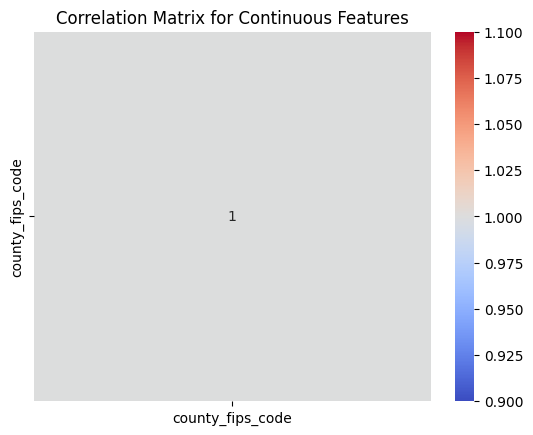

In [214]:
# Read the data from CSV file
train_data = pd.read_csv('train_data.csv')

# Compute the correlation matrix
corr = train_data.corr()

# Plot the correlation matrix as a heatmap
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Continuous Features')
plt.show()

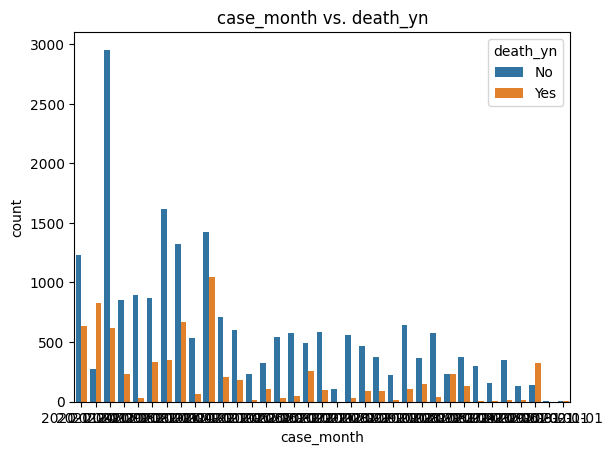

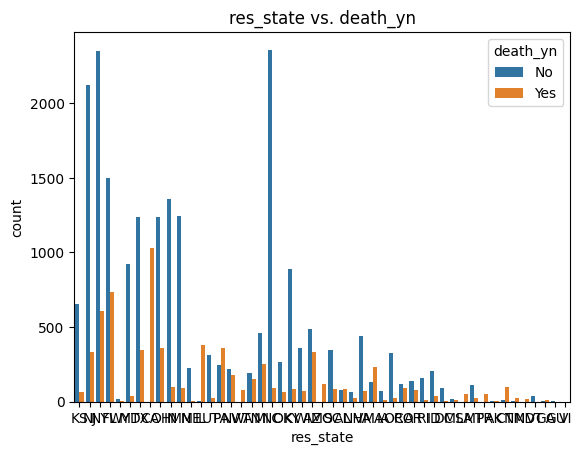

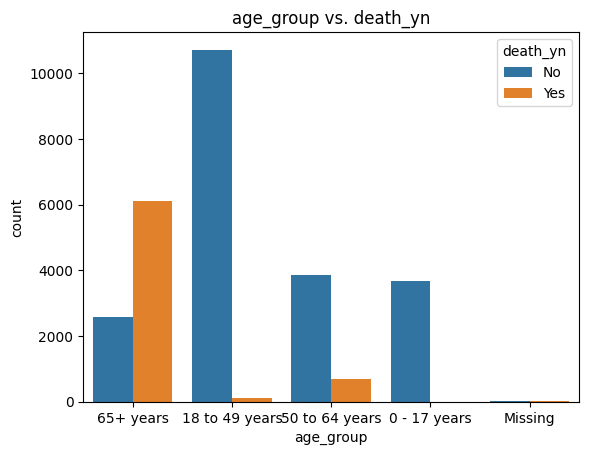

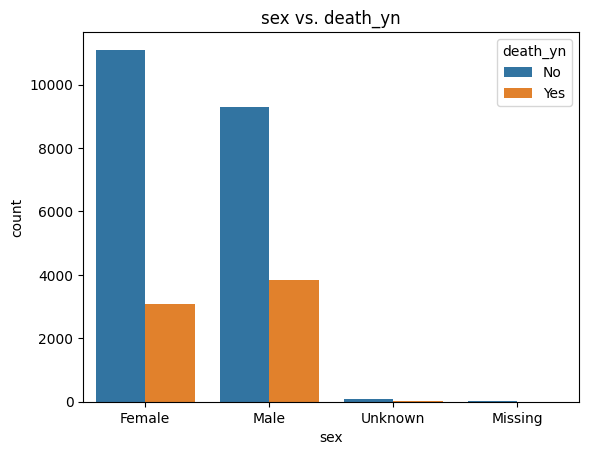

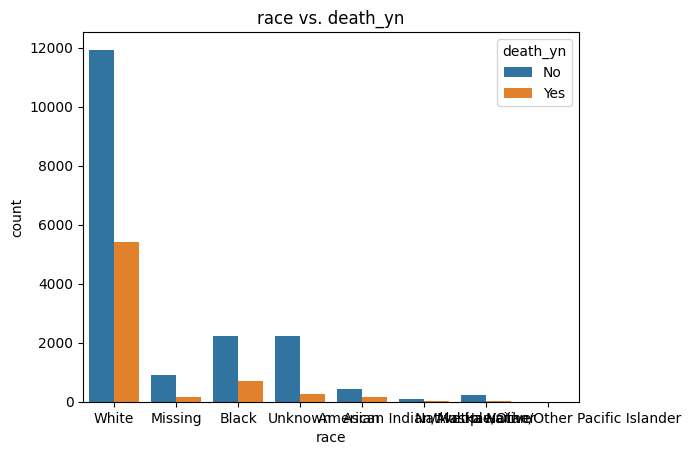

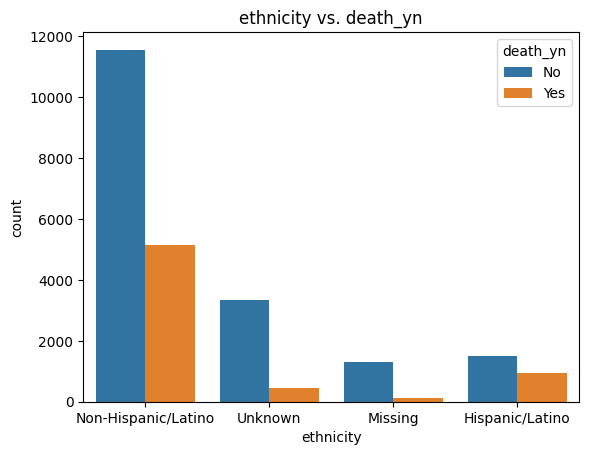

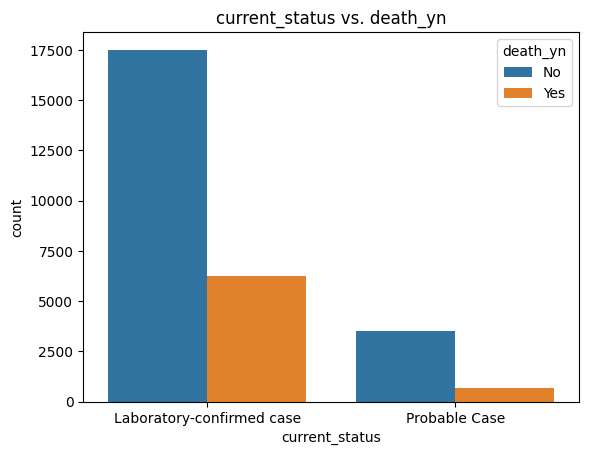

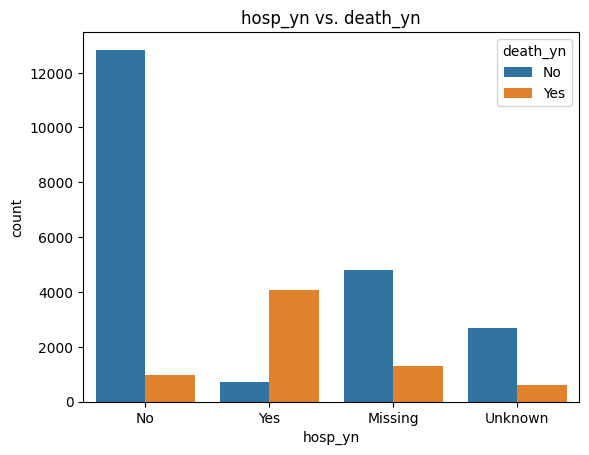

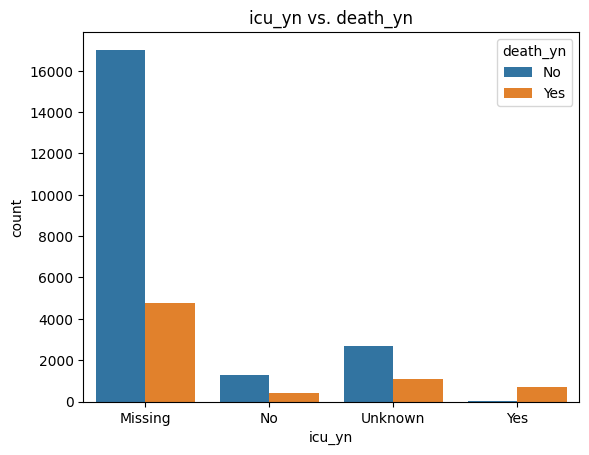

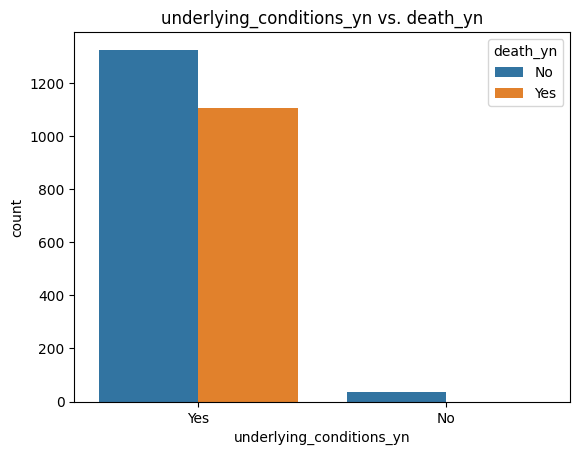

In [219]:
# List of categorical features
categorical_features = [ 'case_month', 'res_state', 'age_group','sex', 'race', 'ethnicity','current_status', 'hosp_yn','icu_yn','underlying_conditions_yn' ]


# Plot the pairwise interaction between each categorical feature and the target feature
for feature in categorical_features:
    plt.figure()
    sns.countplot(x=feature, hue='death_yn', data=train_data)
    plt.title(f'{feature} vs. death_yn')
    plt.show()

(2). [15] **Predictive Modeling:** Linear Regression.  

    - (2.1) On the training set, train a linear regression model to predict the target feature, using only the  descriptive features selected in exercise (1) above. 
    - (2.2) Print the coefficients learned by the model and discuss their role in the model (e.g., interpret the model by analysing each coefficient and how it relates each input feature to the target feature).    
    - (2.3) Print the predicted target feature value for the first 10 training examples. Threshold the predicted target feature value given by the linear regression model at 0.5, to get the predicted class for each example. Print the predicted class for the first 10 examples. Print a few classification evaluation measures computed on the full training set (e.g., Accuracy, Confusion matrix, Precision, Recall, F1) and discuss your findings so far.
    - (2.4) Evaluate the model using classification evaluation measures on the hold-out (30% examples) test set. Compare these results with the evaluation results obtained on the training (70%) dataset. Also compare these results with a cross-validated model (i.e., a new model trained and evaluated using cross-validation on the full dataset). You can use classic k-fold cross-validation or repeated random train/test (70/30) splits. Compare the cross-validation metrics to those obtained on the single train/test split and discuss your findings.
    

(3). [15] **Predictive Modeling:** Logistic Regression.  

    - (3.1) On the training set, train a logistic regression model to predict the target feature, using the descriptive features selected in exercise (1) above.   
    - (3.2) Print the coefficients learned by the model and discuss their role in the model (e.g., interpret the model).    
    - (3.3) Print the predicted target feature value for the first 10 training examples. Print the predicted class for the first 10 examples. Print a few classification evaluation measures computed on the full training set (e.g., Accuracy, Confusion matrix, Precision, Recall, F1) and discuss your findings so far.
    - (3.4) Evaluate the model using classification evaluation measures on the hold-out (30% examples) test set. Compare these results with the evaluation results obtained when using the training (70%) dataset for evaluation. Also compare these results with a cross-validated model (i.e., a new model trained and evaluated using cross-validation on the full dataset). You can use classic k-fold cross-validation or repeated train/test (70/30) splits. Compare the cross-validation metrics to those obtained on the single train/test split and discuss your findings.

(4). [20] **Predictive Modeling:** Random Forest.  

    - (4.1) On the training set, train a random forest model to predict the target feature, using the descriptive features selected in exercise (1) above.   
    - (4.2) Can you interpret the random forest model? Discuss any knowledge you can gain in regard of the working of this model.   
    - (4.3) Print the predicted target feature value for the first 10 training examples. Print the predicted class for the first 10 examples. Print a few classification evaluation measures computed on the full training set (e.g., Accuracy, Confusion matrix, Precision, Recall, F1) and discuss your findings so far.
    - (4.4) Evaluate the model using classification evaluation measures on the hold-out (30% examples) test set. Compare these results with the evaluation results obtained when using the training (70%) dataset for evaluation. Also compare these results with a cross-validated model (i.e., a new model trained and evaluated using cross-validation on the full dataset). You can use classic k-fold cross-validation or repeated train/test (70/30) splits. Compare the cross-validation metrics to those obtained on the single train/test split and to the Random Forest out-of-sample error and discuss your findings.

(5). [25] **Improving Predictive Models.**

    - (5.1) Which model of the ones trained above performs better at predicting the target feature? Is it more   accurate than a simple model that always predicts the majority class (i.e., if 'no' is the majority class in your dataset, the simple model always predicts 'no' for the target feature)? Justify your answers.
    - (5.2) Summarise your understanding of the problem and of your predictive modeling results so far. Can you think of any new ideas to improve the best model so far (e.g., by using furher data prep such as: feature selection, feature re-scaling, creating new features, combining predictive models, or using other domain knowledge)? Please show how your ideas actually work in practice (with code), by training and evaluating your proposed models. Summarise your findings so far. 